In [1]:
## Read EOS projection
import pandas as pd
start_year = 2026
end_year = 2101
def read_eos_projection(ssp):
    eos_projection1 = pd.read_pickle(f"../model/data/tables/params/{ssp}/eos_projection_0000_1600.pkl")
    eos_projection2 = pd.read_pickle(f"../model/data/tables/params/{ssp}/eos_projection_1600_3200.pkl")
    eos_projection = eos_projection1 + eos_projection2
    return eos_projection

In [2]:
## Filter out 365
import numpy as np

def filter_data_by_coordinates(data):
    # Collect all unique coordinate pairs (latitude, longitude)
    coordinates = set((d["latitude"], d["longitude"]) for d in data)
    bad_coordinates = set()

    for coord in coordinates:
        # Collect all models for the current coordinate
        models_for_coord = [d for d in data if (d["latitude"], d["longitude"]) == coord]

        for m in models_for_coord:
            # Check condition for bad pixels
            if np.all(m["predicted_eos"] == 365):
                bad_coordinates.add(coord)
                break  # No need to check more models for these coordinates

    # Filter out entries with bad coordinates
    return [d for d in data if (d["latitude"], d["longitude"]) not in bad_coordinates]

In [ ]:
## Plot EOS trend
def plot_eos_trend(all_predictions, start_year, end_year):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # === Prepare years ===
    years = np.arange(start_year, end_year)
    
    # === Create DataFrame from predictions ===
    df_preds = pd.DataFrame({
        'latitude': [p['latitude'] for p in all_predictions],
        'longitude': [p['longitude'] for p in all_predictions],
        'model': [p['model'] for p in all_predictions],
        'eos': [p['predicted_eos'] for p in all_predictions]
    })
    
    # === Color mapping: brighter colors ===
    model_colors = {
        'CDD': '#A3D4E0',         # Brighter Light Blue
        'DM': '#5BAED8',         # Bright Medium Blue
        'SIAM': '#3B83C4',        # Bright Blue
    
        'SIAMN': '#EA9E88',  # Bright Light Red (Coral)
        'SIAMNP': '#D1837D' # Bright Red (Carmine)
    }
    
    # Set desired order for subplot bars
    models_order = ['CDD', 'DM', 'SIAM', 'SIAMN', 'SIAMNP']
    
    # === Create main figure ===
    fig, ax_main = plt.subplots(figsize=(6, 5))
    
    models = df_preds['model'].unique()
    
    for model in models:
        model_rows = df_preds[df_preds['model'] == model]
    
        # Stack EOS values: shape = (n_coordinates, n_years)
        eos_matrix = np.stack(model_rows['eos'].values)
        eos_df_model = pd.DataFrame(eos_matrix, columns=years)
    
        # Compute mean and std across coordinates
        eos_mean = eos_df_model.mean(axis=0)
        eos_std = eos_df_model.std(axis=0)
    
        # Apply 15-year rolling window smoothing
        mean_smooth = eos_mean.rolling(window=1, center=True, min_periods=1).mean()
        std_smooth = eos_std.rolling(window=1, center=True, min_periods=1).mean()
    
        # Get color for the model
        color = model_colors.get(model, 'black')  # default to black if model is not in dictionary
    
        # Plot smoothed mean line
        ax_main.plot(years, mean_smooth, label=model, color=color, linewidth=2)
    
        # Plot ±0.5, standard deviation shaded region
        ax_main.fill_between(years,
                         mean_smooth - std_smooth/4,  # std should modify mean
                         mean_smooth + std_smooth/4,
                         color='lightgray',
                         alpha=0.2)
    
    # Main plot labels and limits
    ax_main.set_xlabel('Year', fontsize=14)
    ax_main.set_ylabel('EOS (DOY)', fontsize=14)
    ax_main.set_xlim(2026, 2100)
    ax_main.tick_params(axis='x', labelsize=12)
    ax_main.tick_params(axis='y', labelsize=12)
    ax_main.set_ylim(265, 345)

    # === Inset: EOS difference bar plot with error bars ===
    ax_inset = ax_main.inset_axes([0.13, 0.7, 0.3, 0.25])  # [x0, y0, width, height]
    
    # Compute difference per coordinate and calculate mean & half std as error bar
    diff_means = []
    diff_errors = []
    
    for model in models_order:
        model_rows = df_preds[df_preds['model'] == model]
        eos_matrix = np.stack(model_rows['eos'].values)
        eos_df_model = pd.DataFrame(eos_matrix, columns=years)
    
        # Mean EOS for first 5 years and last 5 years per coordinate (axis=1)
        first_10 = eos_df_model.loc[:, start_year:start_year+5].mean(axis=1)
        last_10 = eos_df_model.loc[:, end_year-5:end_year].mean(axis=1)
    
        # Difference per coordinate
        diff_per_coordinate = last_10 - first_10
    
        # Mean and half std deviation for error bar
        diff_means.append(diff_per_coordinate.mean())
        diff_errors.append(0.25 * diff_per_coordinate.std())  # Updated to calculate std properly
    
    colors_ordered = [model_colors.get(m, 'gray') for m in models_order]
    
    # Bar plot with error bars
    bars = ax_inset.bar(np.arange(len(models_order)), diff_means, 
                        yerr=diff_errors, capsize=5,
                        color=colors_ordered)
    print("EOS delays by 2100", diff_means)
    # Set proper xticks and labels
    ax_inset.set_xticks(np.arange(len(models_order)))
    ax_inset.set_xticklabels(models_order, rotation=45, ha='right', fontsize=10)
    
    # Labels and title for inset
    ax_inset.set_ylabel('EOS delay (days)', fontsize=10)
    ax_inset.tick_params(axis='both', labelsize=8)
    ax_inset.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax_inset.tick_params(axis='x', labelsize=10)
    ax_inset.tick_params(axis='y', labelsize=10)
    ax_inset.set_ylim(0, 55)

    # Adjust layout, avoid tight_layout because of inset
    plt.subplots_adjust(right=0.95, bottom=0.15)
    return fig

Plot Fig. 4c

EOS delays by 2100 [np.float64(13.561627069834415), np.float64(14.537745551784433), np.float64(14.399341766944358), np.float64(3.5847269361308247), np.float64(4.897079090815591)]


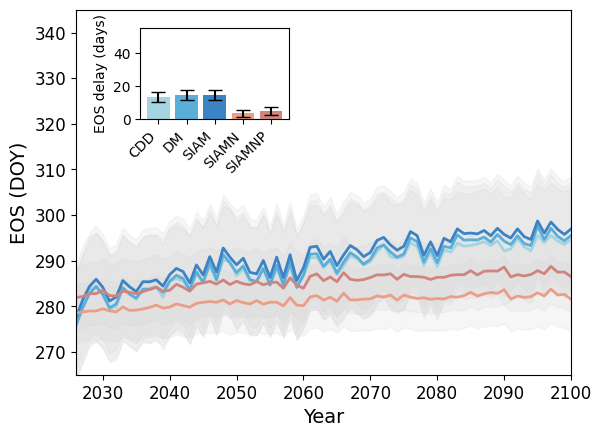

In [7]:
eos_projection_ssp245 = read_eos_projection('ssp245')
clean_eos_projection = filter_data_by_coordinates(eos_projection_ssp245)
fig = plot_eos_trend(eos_projection_ssp245, start_year, end_year)
fig.savefig(f"../results/figure4/ssp245_all_models.png", dpi=300, bbox_inches='tight')

Plot Fig. 4c

EOS delays by 2100 [np.float64(37.912983223924144), np.float64(45.5953735542357), np.float64(44.00174012712306), np.float64(14.344607689903095), np.float64(17.763811607794104)]


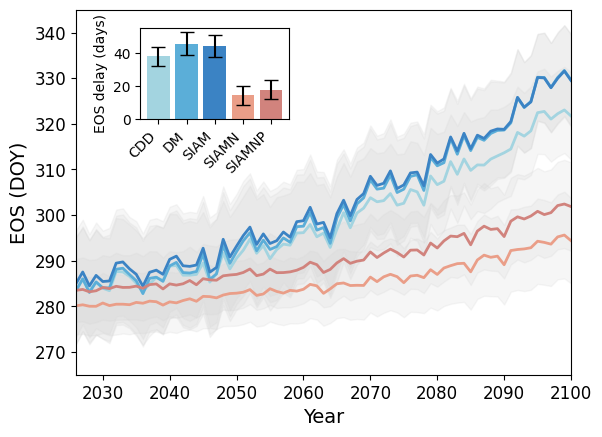

In [9]:
eos_projection_ssp585 = read_eos_projection('ssp585')
clean_eos_projection = filter_data_by_coordinates(eos_projection_ssp585)
fig = plot_eos_trend(eos_projection_ssp585, start_year, end_year)
fig.savefig(f"../results/figure4/ssp585_all_models.png", dpi=300, bbox_inches='tight')